# Overview
In order to choose a small number of representative strains for the gut microbiome, cluster models based on comsumed and excreted metabolites.

In [18]:
# -*- coding:utf-8 -*-
import sys, os
import cobra
import glob
from tqdm import tqdm
from collections import defaultdict
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
print("python version: " + sys.version)
print("cobra version: " + cobra.__version__)
print("pandas version: " + pd.__version__)
print("seaborn version: " + sns.__version__)

python version: 2.7.12 (default, Dec  4 2017, 14:50:18) 
[GCC 5.4.0 20160609]
cobra version: 0.11.3
pandas version: 0.22.0
seaborn version: 0.7.1


In [19]:
os.chdir('/home/jeffl/Dropbox/school/prob-solv/project')
print(os.getcwd())

/home/jeffl/Dropbox/school/prob-solv/project


In [26]:
out_dir = "outputs"
agora_dir = "data/agora"
abundances_dir = "outputs/abundances"
metabolites_file = "%s/metabolites.tsv" % (agora_dir)
# TODO redo with different constraints
# model_constraints = "european"
# species_metabolites_fluxes_file = "%s/species-io-fluxes-%s.tsv" % (agora_dir, model_constraints)
species_metabolites_fluxes_file = "%s/species_io_fluxes.tsv" % (agora_dir)
# this file contains the mapping from the AGORA strain to the MetaPhlAn species
# metaphlan_species_file = "%s/map-agora-to-metaphlan-unique.tsv" % (abundances_dir)
metaphlan_species_file = "%s/map-agora-to-metaphlan-unique-non-zero.tsv" % (abundances_dir)
metaphlan_species = set()
with open(metaphlan_species_file, 'r') as f:
    for line in f:
        if line[0] == '#':
            continue
        metaphlan_species.add(line.rstrip().split('\t')[0])
print("%d species" % (len(metaphlan_species)))

181 species


In [43]:
# read the species-metabolite flux values from the file
all_species_io_met = defaultdict(dict)
# species_io_met contains only the metaphlan_species
species_io_met = defaultdict(dict)
with open(species_metabolites_fluxes_file, 'r') as f:
    metabolites = f.readline().rstrip().split('\t')[1:]
    # make them all lower case
    metabolites = [m.lower() for m in metabolites]
    for line in f:
        line = line.rstrip().split('\t')
        s = line[0]
        # strip extra underscores
        s = s.strip('_')
        fluxes = line[1:]
        for i in range(1,len(metabolites)):
            if fluxes[i] != "NA":
                if s in metaphlan_species:
                    species_io_met[s][metabolites[i]] = float(fluxes[i])
                all_species_io_met[s][metabolites[i]] = float(fluxes[i])
            
print("%d species, %d metabolites" % (len(species_io_met), len(metabolites)))

181 species, 450 metabolites


In [52]:
def get_species_in_out_met(species_io_met):
    # do the out-fluxes first, then the in-fluxes
    species_in_met = defaultdict(set)
    species_out_met = defaultdict(set)
    for s in species_io_met:
        for m in species_io_met[s]:
            # if this is an outgoing flux (i.e., into the extracellular space out of the cell):
            if species_io_met[s][m] >= 0:
                species_in_met[s].add(m)
            elif species_io_met[s][m] <= 0:
                species_out_met[s].add(m)

    print("%d species with in-metabolites, %d with out" % (len(species_in_met), len(species_out_met)))
    in_met_count = len(set(m for met_set in species_in_met.values() for m in met_set))
    out_met_count = len(set(m for met_set in species_out_met.values() for m in met_set))
    print("%d in-metabolites, %d out-metabolites" % (in_met_count, out_met_count))
    
    return species_in_met, species_out_met

In [58]:
def compute_jaccard_and_cluster(met_prots, output_prefix, method="average", ordering=None, forced=False):
    #out_file = "%sjaccard-indeces.txt" % (output_prefix)
    out_file = "%sjaccard-clustered.txt" % (output_prefix)
    if forced or not os.path.isfile(out_file):
        print("Computing overlap using '%s' method" % (method))
        # first compute the jaccard index of every met pair 
        # then write the overlap of the hits (rec and TF) and take some sort of ratio
        # dictionary of metA-metB pairs as the keys and the jaccard index as the overlap
        overlaps = {metA: {} for metA in met_prots}
        for metA in met_prots:
            for metB in met_prots:
                # create a symmetrical matrix of the overlaps so that they can be clustered correctly
                if metA < metB:
                    metA_prots = set(met_prots[metA])
                    metB_prots = set(met_prots[metB])
                    jaccard_index = len(metA_prots.intersection(metB_prots)) / float(len(metA_prots.union(metB_prots))) 
                    overlaps[metA][metB] = jaccard_index
                    overlaps[metB][metA] = jaccard_index

        # convert to pandas dataframe for better visualization
        df = pd.DataFrame(overlaps, dtype='float')
        df = df.fillna(0)

        # If the indeces were passed in, don't re-cluster the output. 
        # if the ordergin (ordering) is passed in to the function, use that instead
        if ordering is None:
            # perform the clustering here, and then write the clustered matrix to a CSV
            cg = sns.clustermap(df, method=method)
            # get the ordering of the mets after clustering
            column_indeces = cg.dendrogram_col.reordered_ind
            df = re_order_dataframe(df, column_indeces=column_indeces)
            # remove cg so it isn't plotted
            del cg
            plt.close()
        else:
            df = re_order_dataframe(df, new_columns=ordering)
        print("Writing overlap to '%s'" % (out_file))
        # write the jaccard indeces
        df.round(4).to_csv(out_file)

    else:
        print("reading in overlap file '%s'. Use --forced to overwite it." % (out_file))
        df = pd.read_csv(out_file, index_col=0)

    return df


In [46]:
def re_order_dataframe(df, column_indeces=None, new_columns=None):
    if column_indeces is not None:
        cols = df.columns.tolist()
        new_columns = []
        for col_index in column_indeces:
            new_columns.append(cols[col_index])
    # for some reason, the index was the integer of the chemical ID. Map it to the string
    df.index = df.index.map(str)
    #df = df[new_cols]
    # the matrix is symmetrical so also reindex the rows
    df = df.reindex(new_columns, columns=new_columns)
    return df

In [47]:
def plot_jaccard_overlap(overlaps, output_prefix, method="average", cluster=False, 
                         title="", xlabel="", ylabel="",
                         row_colors=None, col_colors=None, label_colors=None, pdf=False, forced=False):
    # plot the jaccard indeces as a clustered heatmap
    out_file = "%sjaccard-heatmap.png" % (output_prefix)

    if os.path.isfile(out_file) and not forced:
        print("%s already exists. Use --forced to overwrite it" % (out_file))
        return

    if cluster:
        print("Plotting clustered overlap heatmap of the jaccard indeces to the file %s" % (out_file))
        #sns.heatmap(df).savefig(out_file)
        # taken from here: https://stanford.edu/~mwaskom/software/seaborn/generated/seaborn.clustermap.html
        # color rows based on the genus
        cg = sns.clustermap(overlaps, method=method, row_colors=row_colors, col_colors=col_colors, 
                            cmap=sns.cubehelix_palette(8, dark=0, light=0.95, as_cmap=True, reverse=True))
        # remove the tick labels
        cg.ax_heatmap.yaxis.set_ticklabels([])
        cg.ax_heatmap.xaxis.set_ticklabels([])
        # could rotate the labels, but they still overlap because they're too big
        #plt.setp(cg.ax_heatmap.yaxis.get_majorticklabels(), rotation=0)
        #plt.setp(cg.ax_heatmap.xaxis.get_majorticklabels(), rotation=1)
        if label_colors is not None:
            import matplotlib.patches as mpatches
            legend_TN = []
            for l in label_colors.index:
                legend_TN.append(mpatches.Patch(color=label_colors[l], label=l))
            l2=cg.ax_heatmap.legend(loc='center left',bbox_to_anchor=(1.01,0.85),handles=legend_TN,frameon=True)
            l2.set_title(title='Phylum',prop={'size':10})
        #plt.legend()
#         plt.title(title)
        # remove the dendrogram
        cg.ax_row_dendrogram.set_visible(False)
        cg.savefig(out_file)
        if pdf:
            print("Also generating pdf: %s " % out_file.replace('.png', '.pdf'))
            cg.savefig(out_file.replace('.png', '.pdf'))

    #if heatmap:
    else:
        # start a new figure to plot a non-clustered heatmap
        print("Plotting overlap heatmap of the jaccard indeces to the file %s" % (out_file))
        fig, ax = plt.subplots()
        cg = sns.heatmap(overlaps)
        # TODO remove the tick labels
        #plt.yticks(rotation=0)
        #plt.xticks(rotation='vertical')
        import matplotlib.patches as mpatches
        legend_TN = []
        for l in label_colors.index:
            legend_TN.append(mpatches.Patch(color=label_colors[l], label=l))
        l2=cg.ax_heatmap.legend(loc='center left',bbox_to_anchor=(1.01,0.85),handles=legend_TN,frameon=True)
        l2.set_title(title='Phylum',prop={'size':10})

        plt.savefig(out_file)
        if pdf:
            print("Also generating pdf: %s " % (out_file.replace('.png', '.pdf')))

In [48]:
microbes_formatted_file = "%s/microbes-formatted.tsv" % (agora_dir)

if os.path.isfile(microbes_formatted_file):
    microbes_df = pd.read_csv(microbes_formatted_file, sep="\t", index_col=0)
else:
    # get the genus for each phyla, and make colors for each of them
    microbes_df = pd.read_csv("%s/microbes.tsv" % (out_dir), sep="\t")
    # some have trailing whitespace
    microbes_df.organism = microbes_df.organism.str.strip()
    microbes_df.replace('\s+', '_', regex=True, inplace=True)
    microbes_df.replace('-', '_', regex=True, inplace=True)
    microbes_df.replace('/', '_', regex=True, inplace=True)
    # there are also cases where the microbes file has a period and the species doesn't
    # for example: Acidaminococcus_sp._D21 is Acidaminococcus_sp_D21 in the metabolites file
    microbes_df.replace('sp\.', 'sp', regex=True, inplace=True)
    microbes_df.replace('str\.', 'str', regex=True, inplace=True)
    microbes_df.replace('cf\.', 'cf', regex=True, inplace=True)
    microbes_df.replace('\.', '_', regex=True, inplace=True)
    microbes_df.replace(':', '_', regex=True, inplace=True)
    microbes_df.replace('\,', '', regex=True, inplace=True)
    microbes_df.replace('\(', '', regex=True, inplace=True)
    microbes_df.replace('\)', '', regex=True, inplace=True)
    # some organisms have multiple strains (I'm assuming) specified by '='. They're not present in the metabolites file
    microbes_df.replace('_=.+', '', regex=True, inplace=True)
    # some have extra quotation marks
    microbes_df.replace("'", '', regex=True, inplace=True)
    microbes_df.head()
    # write the correctly formatted species to a file
    microbes_df.to_csv(microbes_formatted_file, sep='\t')

In [49]:
# write the species for which we have abundances to a file
# microbes_w_abundances_df = microbes_df[microbes_df.organism.isin(species_io_met.keys())]
# microbes_w_abundances_df.to_csv("%s/microbes-with-abundances.tsv" % (agora_dir), sep='\t')

In [65]:
species_to_phylum = dict(zip(microbes_df.organism, microbes_df.phylum))
phyla = microbes_df.phylum.unique()

#colors = sns.color_palette("Set1", len(phyla))
colors = sns.color_palette("BuPu", 6) + \
            sns.color_palette("OrRd", 6) + \
            sns.color_palette("YlGn", 6) + \
            sns.color_palette("RdPu", 6) + \
            sns.color_palette("PuBu", 30)
phylum_colors = {}
for i in range(len(phyla)):
    phylum_colors[phyla[i]] = colors[i]
    
# some species just don't match. Match them up here
extra_map = {
    "Serratia_marcescens_subsp_marcescens_Db11": "Serratia_marcescens_Db11",
    "Clostridium_saccharoperbutylacetonicum_N1_4_HMT": "Clostridium_saccharoperbutylacetonicum_N1_4HMT",
}
    
# color the species by the phylum
species_colors = {}
for s in all_species_io_met:
    s2 = extra_map.get(s, s)
    species_colors[s] = phylum_colors[species_to_phylum[s2]]


## Cluster based on both in and out metabolites
- Limit the out metabolites to the 55 secreted metabolites
  - Need to ensure the metabolies important to the immune system are still represented (see [this spreadsheet](https://docs.google.com/spreadsheets/d/1cL19gcmZvIzR7LrAsn5ExjZ1Mj3iT--qywxC0twENGE/edit?usp=sharing))
- cluster based on the combination of both the consumed (in) and secreted (out) metabolites

First use all 818 models, then limit it to the 268 models with non-zero abundance

In [56]:
# compute the jaccard index and cluster
# cluster the GO terms based on how similar their annotated proteins are
# use the jaccard index
forced = True
force_plot = True
clustering_method = "ward"
#clustering_method = "average"

In [64]:
all_output_prefix = "%s/clusters/in-out-met-metaphlan-%s-" % (out_dir, clustering_method)
#rep_sp_most_immune_file = "%s/viz/in-out-met-metaphlan-ward-%d-clusters-most-immune.tsv" % (out_dir, num_clust)
output_prefix = "%s/clusters/in-out-met-eu-nonzero-ab-%s-" % (out_dir, clustering_method)

In [59]:
species_in_met, species_out_met = get_species_in_out_met(all_species_io_met)
# to cluster using both the consumed and secreted metabolites, prepent in and out to the metabolite name
species_in_out_met = {}
for s in species_in_met:
    in_met = set('in'+m for m in species_in_met[s])
    out_met = set('out'+m for m in species_out_met[s])
    species_in_out_met[s] = in_met.union(out_met)
    
df_all = compute_jaccard_and_cluster(species_in_out_met, output_prefix, method=clustering_method, forced=forced)

818 species with in-metabolites, 818 with out
447 in-metabolites, 233 out-metabolites
Computing overlap using 'ward' method
Writing overlap to 'outputs/clusters/in-out-met-metaphlan-ward-jaccard-clustered.txt'


Plotting clustered overlap heatmap of the jaccard indeces to the file outputs/clusters/in-out-met-eu-nonzero-ab-ward-jaccard-heatmap.png


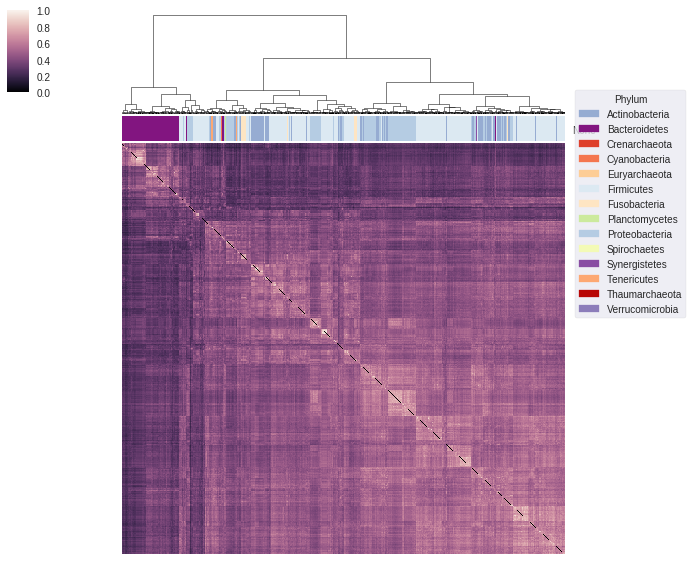

In [66]:
# now plot the clustering results
plot_jaccard_overlap(df_all, output_prefix, method=clustering_method, cluster=True, 
                     col_colors=pd.Series(species_colors), label_colors=pd.Series(phylum_colors), forced=force_plot)

In [67]:
species_in_met, species_out_met = get_species_in_out_met(species_io_met)
# to cluster using both the consumed and secreted metabolites, prepent in and out to the metabolite name
species_in_out_met = {}
for s in species_in_met:
    in_met = set('in'+m for m in species_in_met[s])
    out_met = set('out'+m for m in species_out_met[s])
    species_in_out_met[s] = in_met.union(out_met)
    
df_nonzero_ab = compute_jaccard_and_cluster(species_in_out_met, output_prefix, method=clustering_method, forced=forced)

181 species with in-metabolites, 181 with out
418 in-metabolites, 152 out-metabolites
Computing overlap using 'ward' method
Writing overlap to 'outputs/clusters/in-out-met-eu-nonzero-ab-ward-jaccard-clustered.txt'


Plotting clustered overlap heatmap of the jaccard indeces to the file outputs/clusters/in-out-met-eu-nonzero-ab-ward-jaccard-heatmap.png


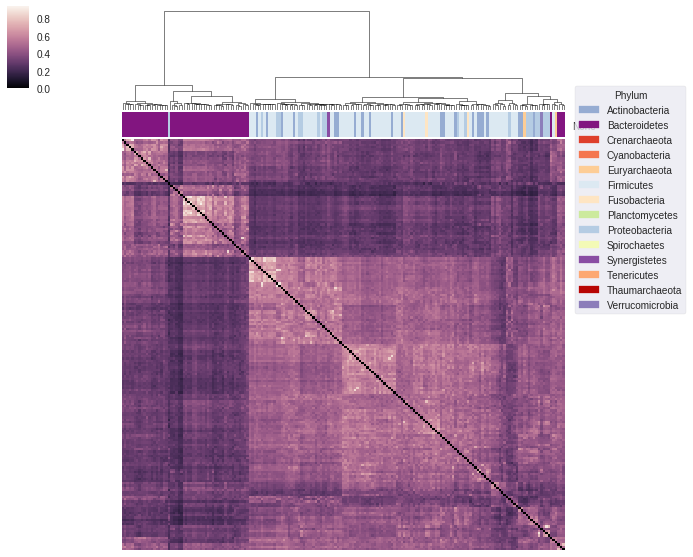

In [68]:
# now plot the clustering results
plot_jaccard_overlap(df_nonzero_ab, output_prefix, method=clustering_method, cluster=True, 
                     col_colors=pd.Series(species_colors), label_colors=pd.Series(phylum_colors), forced=force_plot)

### Extract Clusters
- Need to extract meaningful clusters

Questions:
- How can I ensure that fairly abundant species are represented?
  - What # of clusters should I use? Should I try to do anything fancy like statistically significant clusters?
- If I choose a representative species at random
  - What is my coverage of the secreted metabolites?
  - How much overlap is there between the consumed and secreted metaoblites of the representative species? I need to make sure they can grow together

In [61]:
from scipy.cluster.hierarchy import fcluster, linkage

def choose_clusters(df, num_clusters=10, clustering_method='ward', out_file=None):
    cl = linkage(df, method=clustering_method)
    # the maxclust method says I want to choose the best 10 clusters
    # another option would be to choose a distance cutoff
    fl = fcluster(cl,num_clust,criterion='maxclust')

    # TODO ensure this dataframe is ordered by the hierarchical clustering
    species_clusters = {}
    cluster_species = defaultdict(set)
    species = df.index.tolist()
    for i, s in enumerate(species):
        cluster = fl[i]
        species_clusters[s] = cluster
        cluster_species[cluster].add(s)

    # write the cluster assignments to a file
    if out_file is not None:
        print("Writing cluster assignments to %s" % (out_file))
        with open(out_file, 'w') as f:
            f.write(''.join("%s\t%d\n" % (s, c) for s, c in sorted(species_clusters.items(), key=lambda x: x[1])))
        
    return species_clusters, cluster_species

In [62]:
def get_cluster_colors(df, num_clust):
    num_colors = (num_clust / 4)+1
    colors = sns.color_palette("BuPu", num_colors) + \
                sns.color_palette("OrRd", num_colors) + \
                sns.color_palette("YlGn", num_colors) + \
                sns.color_palette("RdPu", num_colors) + \
                sns.color_palette("PuBu", 30)
    clust_colors = {}
    for i in range(1,num_clust+1):
        clust_colors[i] = colors[i]

    # color the species by the cluster they're in
    col_colors = []
    species = df.index.tolist()
    for s in species:
        cluster = species_clusters[s]
        col_colors.append(clust_colors[cluster])
    return col_colors

In [71]:
# now write the species in each cluster to a file
num_clust = 10
out_file = "%s%d-clusters.tsv" % (output_prefix, num_clust)
species_clusters, cluster_species = choose_clusters(df_nonzero_ab, num_clusters=num_clust, clustering_method=clustering_method, out_file=out_file)

Writing cluster assignments to outputs/clusters/in-out-met-eu-nonzero-ab-ward-10-clusters.tsv


Plotting clustered overlap heatmap of the jaccard indeces to the file outputs/clusters/in-out-met-eu-nonzero-ab-ward-10-clusters-jaccard-heatmap.png


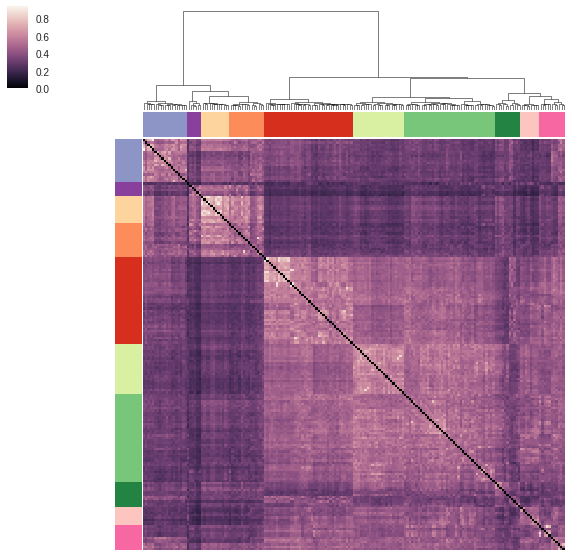

In [72]:
# now plot the clusters by adding a color band across the top (and side?)
col_colors = get_cluster_colors(df_nonzero_ab, num_clust)
out_prefix = "%s%d-clusters-" % (output_prefix, num_clust)
plot_jaccard_overlap(df_nonzero_ab, out_prefix, method=clustering_method, cluster=True, 
                     row_colors=col_colors, col_colors=col_colors, forced=force_plot)

In [76]:
# now write the species in each cluster to a file
num_clust = 20
out_file = "%s%d-clusters.tsv" % (all_output_prefix, num_clust)
species_clusters, cluster_species = choose_clusters(df_all, num_clusters=num_clust, clustering_method=clustering_method, out_file=out_file)

Writing cluster assignments to outputs/clusters/in-out-met-metaphlan-ward-20-clusters.tsv


Plotting clustered overlap heatmap of the jaccard indeces to the file outputs/clusters/in-out-met-metaphlan-ward-20-clusters-jaccard-heatmap.png


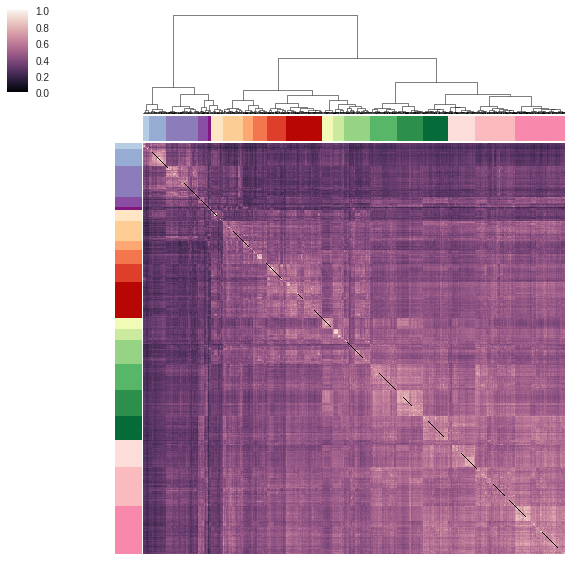

In [80]:
# now plot the clusters by adding a color band across the top (and side?)
col_colors = get_cluster_colors(df_all, num_clust)
out_prefix = "%s%d-clusters-" % (all_output_prefix, num_clust)
plot_jaccard_overlap(df_all, out_prefix, method=clustering_method, cluster=True, 
                     row_colors=col_colors, col_colors=col_colors, forced=force_plot)

# Representative species
Below is the method to choose a representative set of species for each cluster uniformly at random. 
To get the most abundant species for each cluster, see the notebook `cluster-abundances.ipynb`

In [73]:
# now choose a "representative" species uniformly at random
import random
def choose_representative_models(cluster_species, seed=None, verbose=False):
    random.seed(a=seed)
    representative_models = []
    for cluster in cluster_species:
        s = random.sample(cluster_species[cluster], 1)[0]
        representative_models.append(s)
        if verbose is True:
            print("Representing cluster %d: %s" % (cluster, s))
    return representative_models
    
#print("Representative models:")
#print(representative_models)
# choose_representative_models(cluster_species, seed=1, verbose=True)

818 species with in-metabolites, 818 with out
447 in-metabolites, 233 out-metabolites
74% (+-4.9%) all in-metabolites covered
35% (+-2.3%) all out-metabolites covered
4 (+-0.85) immune metabolites covered
Greatest number of immune metabolites covered: 7


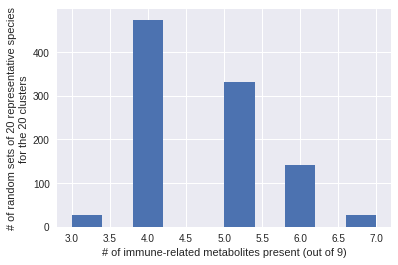

In [78]:
# Analyze the coverage of the in and out metabolites
import numpy as np
species_in_met, species_out_met = get_species_in_out_met(all_species_io_met)
all_in_met = set(m for met_set in species_in_met.values() for m in met_set)
all_out_met = set(m for met_set in species_out_met.values() for m in met_set)
# set of metabolites that interact with the immune system
immune_met = set([
    "acetate",
    "formate",
    "propionate",
    "butyrate",
    "isobutyrate, 2-methylpropanoate",
    "isovalerate, 3-methylbutanoate",
    "l-kynurenine",
    "putrescine",
    "spermidine",
])

most_immune_met = 0
model_with_most_immune_met = None
dist_perc_in = []
dist_perc_out = []
dist_num_immune = []
for i in range(1,1001):
    representative_models = choose_representative_models(cluster_species, seed=i)
#     representative_models = choose_representative_models(cluster_species)
    rep_models_in = set()
    rep_models_out = set()
    for s in representative_models:
        rep_models_in.update(species_in_met[s])
        rep_models_out.update(species_out_met[s])

    perc_in = round((len(rep_models_in) / float(len(all_in_met))) * 100)
    perc_out = round((len(rep_models_out) / float(len(all_out_met))) * 100)
    #print(rep_models_out.intersection(immune_met))
    num_immune = len(rep_models_out & immune_met)
    if num_immune > most_immune_met:
        most_immune_met = num_immune
        model_with_most_immune_met = representative_models
    #print("%d%% (%d/%d) in-metabolites covered" % (perc_in, len(rep_models_in), len(all_in_met)))
    #print("%d%% (%d/%d) out-metabolites covered" % (perc_out, len(rep_models_out), len(all_out_met)))
    dist_perc_in.append(perc_in)
    dist_perc_out.append(perc_out)
    dist_num_immune.append(num_immune)
    
print("%d%% (+-%0.1f%%) all in-metabolites covered" % (np.mean(dist_perc_in), np.std(dist_perc_in)))
print("%d%% (+-%0.1f%%) all out-metabolites covered" % (np.mean(dist_perc_out), np.std(dist_perc_out)))    

print("%d (+-%0.2f) immune metabolites covered" % (np.mean(dist_num_immune), np.std(dist_num_immune)))
print("Greatest number of immune metabolites covered: %d" % (most_immune_met))
# TODO now plot the distribution
plt.plot()
plt.hist(dist_num_immune)
plt.xlabel("# of immune-related metabolites present (out of 9)")
plt.ylabel("# of random sets of %d representative species\nfor the %d clusters" % (num_clust, num_clust))

In [37]:
immune_counts = {im: set() for im in immune_met}
for s in species_out_met:
    for im in immune_met:
        if im in species_out_met[s]:
            immune_counts[im].add(s)
for im in sorted(immune_counts, key=lambda x: len(immune_counts[x]), reverse=True):
    print("%s: %d" % (im, len(immune_counts[im])))
    if len(immune_counts[im]) < 5:
        print("\t%s" % (', '.join(immune_counts[im])))

acetate: 170
formate: 131
propionate: 90
butyrate: 35
putrescine: 2
	Dialister_succinatiphilus_YIT_11850, Escherichia_coli_UTI89_UPEC
isobutyrate, 2-methylpropanoate: 1
	Catenibacterium_mitsuokai_DSM_15897
l-kynurenine: 0
	
spermidine: 0
	
isovalerate, 3-methylbutanoate: 0
	


In [25]:
print("representative model set with the most # of immune-related metabolites")
out_str = "cluster\tspecies\n"
out_str += ''.join("%d\t%s\n" % (i+1, s) for i, s in enumerate(model_with_most_immune_met))
print(out_str)
# and write them to a file
out_file = "%smost-immune.tsv" % (out_prefix)
print("writing %s" % (out_file))
with open(out_file, 'w') as out:
    out.write(out_str)

representative model set with the most # of immune-related metabolites
cluster	species
1	Bacteroides_thetaiotaomicron_VPI_5482
2	Bacteroides_sp_2_2_4
3	Parabacteroides_johnsonii_DSM_18315
4	Prevotella_oralis_ATCC_33269
5	Eubacterium_eligens_ATCC_27750
6	Slackia_exigua_ATCC_700122
7	Dorea_longicatena_DSM_13814
8	Clostridium_bartlettii_DSM_16795
9	Streptococcus_sp_I_P16
10	Blautia_hydrogenotrophica_DSM_10507
11	Brevundimonas_bacteroides_DSM_4726
12	Clostridium_hylemonae_DSM_15053
13	Sutterella_wadsworthensis_3_1_45B
14	Enterobacteriaceae_bacterium_9_2_54FAA
15	Bacillus_megaterium_DSM319
16	Peptostreptococcus_stomatis_DSM_17678
17	Brachybacterium_paraconglomeratum_LC44
18	Neisseria_elongata_subsp_glycolytica_ATCC_29315
19	Rothia_aeria_F0474
20	Staphylococcus_hominis_subsp_hominis_C80

writing agora-1_02/viz/in-out-met-metaphlan-ward-20-clusters-most-immune.tsv


In [81]:
rep_models_in = set()
rep_models_out = set()
for s in model_with_most_immune_met:
    rep_models_in.update(species_in_met[s])
    rep_models_out.update(species_out_met[s])

perc_in = round((len(rep_models_in) / float(len(all_in_met))) * 100)
perc_out = round((len(rep_models_out) / float(len(all_out_met))) * 100)
print("%d%% of all consumed metabolites covered" % (perc_in))
print("%d%% of all secreted metabolites covered" % (perc_out))

84% of all consumed metabolites covered
37% of all secreted metabolites covered


In [40]:
curr_df = microbes_df[microbes_df.organism.isin(representative_models)]
microbes_w_abundances_df = microbes_df[microbes_df.organism.isin(species_io_met.keys())]
print("For a random representative set of %d species:" % (len(representative_models)))
for level in ['phylum', 'mclass', 'order', 'family', 'genus']:
    print("# %s: %d" % (level, curr_df[level].nunique()))
print("\nAcross all %d species:" % (len(species_io_met)))
for level in ['phylum', 'mclass', 'order', 'family', 'genus']:
    print("# %s: %d" % (level, microbes_w_abundances_df[level].nunique()))

# microbes_df[microbes_df.organism.isin(model_with_most_immune_met)]['family'].nunique()
# microbes_df[microbes_df.organism.isin(model_with_most_immune_met)]['genus'].nunique()
# print("# phylum: %d " % (['phylum'].nunique())
# microbes_df[microbes_df.organism.isin(model_with_most_immune_met)]['mclass'].nunique()
# microbes_df[microbes_df.organism.isin(model_with_most_immune_met)]['order'].nunique()

For a random representative set of 15 species:
# phylum: 5
# mclass: 9
# order: 9
# family: 12
# genus: 13

Across all 181 species:
# phylum: 8
# mclass: 15
# order: 22
# family: 39
# genus: 80
